In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Import Libraries and initialize API keys

In [1]:
%config IPCompleter.greedy=True
import requests
import os
import urllib
import json
import pandas as pd
import matplotlib.pyplot as plot
import datetime as dt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.utils import plot_model
from sklearn.model_selection import train_test_split

domain_name = "https://www.alphavantage.co/query?"
API_KEY = "S7XHP1NO02N5O9F0"

# Methods to load Stock Price Data from API to CSV

In [2]:
def buildURL(symbol, apikey, function="TIME_SERIES_DAILY",  outputsize="compact"):
    url = domain_name + "function=" + function
    if (symbol):
        url += "&symbol=" + symbol
    if (outputsize):
        url += "&outputsize=" + outputsize
    if (apikey):
        url += "&apikey=" + apikey
    return url

def loadStockDataToCsv(get_url, file_name):
    if not os.path.exists(file_name):
        with urllib.request.urlopen(get_url) as url:
            data = json.loads(url.read().decode())
            data = data['Time Series (Daily)']
            df = pd.DataFrame(columns=['index','Date','Low','High','Close','Open'])
            ind=len(data)-1
            for k,v in data.items():
                date = dt.datetime.strptime(k, '%Y-%m-%d')
                data_row = [ind, date.date(),float(v['3. low']),float(v['2. high']),
                            float(v['4. close']),float(v['1. open'])]
                df.loc[-1,:] = data_row
                df.index = df.index + 1
                ind = ind - 1
        print('Data saved to : %s'%file_name)        
        df.to_csv(file_name)
    
    else:
        print("Data already Loaded. Please read the csv file: " + file_name)

# Load data to CSV

In [3]:
getUrl = buildURL("AAPL", API_KEY, "TIME_SERIES_DAILY", "full")
print("Get URL : ", getUrl)

file_name = "DAILY_STOCK_PRICE_AAPL.csv"
loadStockDataToCsv(getUrl, file_name)

Get URL :  https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=AAPL&outputsize=full&apikey=S7XHP1NO02N5O9F0
Data saved to : DAILY_STOCK_PRICE_AAPL.csv


# Read data from CSV and sort the rows by Date

In [4]:
csv_data = pd.read_csv(file_name, index_col="index")

date_sorted_columns = csv_data.sort_values("Date")
date_sorted_columns.head()

,Unnamed: 0,Date,Low,High,Close,Open
index,,,,,,
0,0,1999-11-01,77.37,80.69,77.62,80.00
1,1,1999-11-02,77.31,81.69,80.25,78.00
2,2,1999-11-03,81.00,83.25,81.50,81.62
3,3,1999-11-04,80.62,85.37,83.62,82.06
4,4,1999-11-05,84.00,88.37,88.31,84.62


# Visualize the imported data

Text(0, 0.5, 'Stock Price')

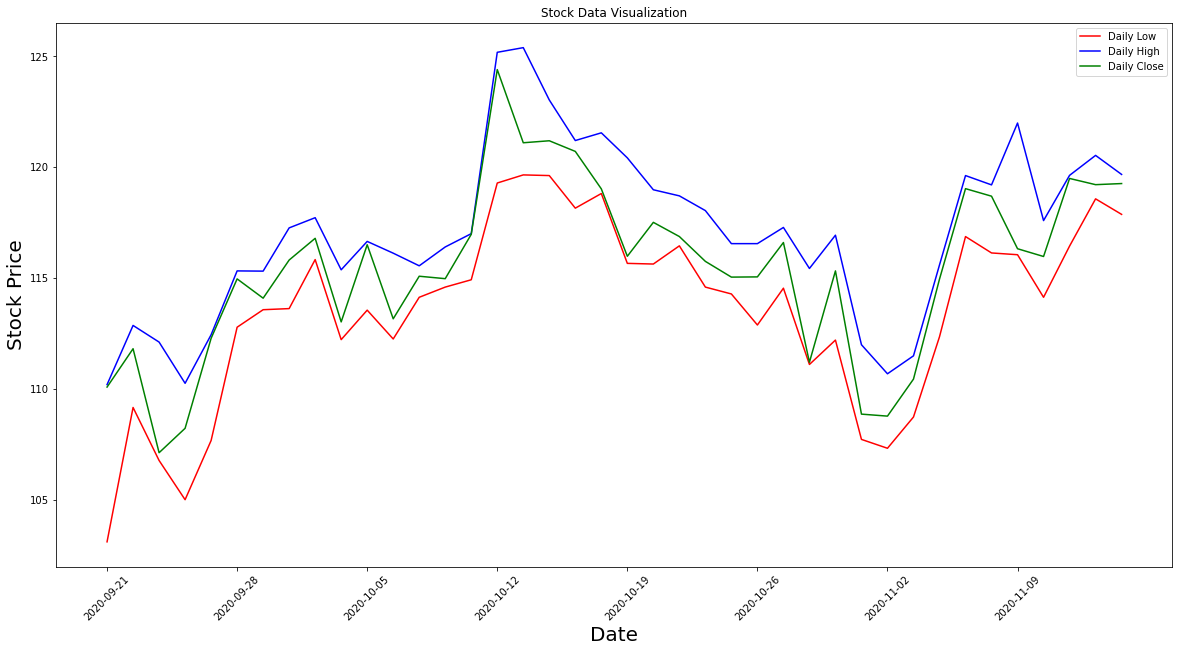

In [5]:
plot.figure(figsize = (20,10))
plot.title("Stock Data Visualization")
plot.plot(range(40), date_sorted_columns[-40:]['Low'], label="Daily Low", color="red");
plot.plot(range(40), date_sorted_columns[-40:]['High'], label="Daily High", color="blue");
plot.plot(range(40), date_sorted_columns[-40:]['Close'], label="Daily Close", color="green");
plot.xticks(range(0, 40, 5), date_sorted_columns[-40:]['Date'].loc[::5], rotation=45);

plot.legend(loc='best')
plot.xlabel('Date',fontsize=20)
plot.ylabel('Stock Price',fontsize=20)

In [6]:
high_data = date_sorted_columns.filter(['High'])
low_data = date_sorted_columns.filter(['Low'])
close_data = date_sorted_columns.filter(['Close'])

all_high_prices = high_data.values
all_low_prices = low_data.values
all_closing_prices = close_data.values
print("Size of total data set = ", len(all_high_prices))

Size of total data set =  5295


# Normalize the data and build train and test instances

In [7]:
normalizer = MinMaxScaler(feature_range=(0,1))
normalized_high_prices = normalizer.fit_transform(all_high_prices.reshape(-1,1))

WINDOW_SIZE = 60

high_train, high_test = train_test_split(normalized_high_prices, test_size=0.2, shuffle=False)
total_training_instances= len(high_train)
print("Train size = ", total_training_instances)
print("Test size = ", len(high_test))

high_train_x = []
high_train_y = []

for i in range(WINDOW_SIZE, len(high_train)):
    high_train_x.append(high_train[i-WINDOW_SIZE:i,0])
    high_train_y.append(high_train[i,0])

high_train_x, high_train_y = np.array(high_train_x), np.array(high_train_y)
high_train_x = np.reshape(high_train_x, (high_train_x.shape[0], high_train_x.shape[1], 1))

high_test_data = normalized_high_prices[total_training_instances-WINDOW_SIZE: , :]
high_test_x = []

high_test_y = all_high_prices[total_training_instances:]

for i in range(60, len(high_test_data)):
    high_test_x.append(high_test_data[i-WINDOW_SIZE:i,0])
    
high_test_x = np.array(high_test_x)
high_test_x = np.reshape(high_test_x,(high_test_x.shape[0], high_test_x.shape[1],1))

Train size =  4236
Test size =  1059


# Build the Model for LSTM

In [8]:
model = Sequential()
model.add(LSTM(units=100, return_sequences=True,input_shape=(high_train_x.shape[1],1)))
model.add(LSTM(units=100, return_sequences=False))
model.add(Dense(units=50))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

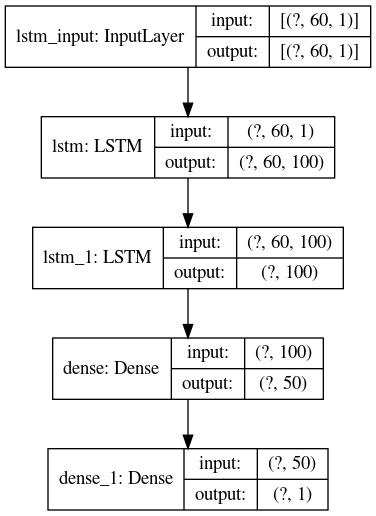

In [9]:
plot_model(
    model, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='TB', expand_nested=False, dpi=96
)

# Train the Model

In [10]:
history = model.fit(high_train_x, high_train_y, batch_size=1, epochs=10)

Epoch 1/10
4176/4176 [==============================] - 23s 6ms/step - loss: 0.0019
Epoch 2/10
4176/4176 [==============================] - 23s 5ms/step - loss: 0.0010
Epoch 3/10
4176/4176 [==============================] - 23s 6ms/step - loss: 7.9613e-04
Epoch 4/10
4176/4176 [==============================] - 24s 6ms/step - loss: 6.1107e-04
Epoch 5/10
4176/4176 [==============================] - 23s 6ms/step - loss: 4.8907e-04
Epoch 6/10
4176/4176 [==============================] - 23s 6ms/step - loss: 4.9587e-04
Epoch 7/10
4176/4176 [==============================] - 23s 5ms/step - loss: 4.9464e-04
Epoch 8/10
4176/4176 [==============================] - 25s 6ms/step - loss: 4.5565e-04
Epoch 9/10
4176/4176 [==============================] - 24s 6ms/step - loss: 4.7902e-04
Epoch 10/10
4176/4176 [==============================] - 24s 6ms/step - loss: 3.7127e-04


In [13]:
history.history

{'loss': [0.0019467142410576344,
  0.0010413354029878974,
  0.000796134932897985,
  0.0006110707181505859,
  0.0004890679847449064,
  0.0004958651843480766,
  0.0004946366534568369,
  0.000455650471849367,
  0.00047902402002364397,
  0.0003712666512001306]}

# Viewing the Loss vs Epochs plot

AttributeError: module 'matplotlib.pyplot' has no attribute 'legent'

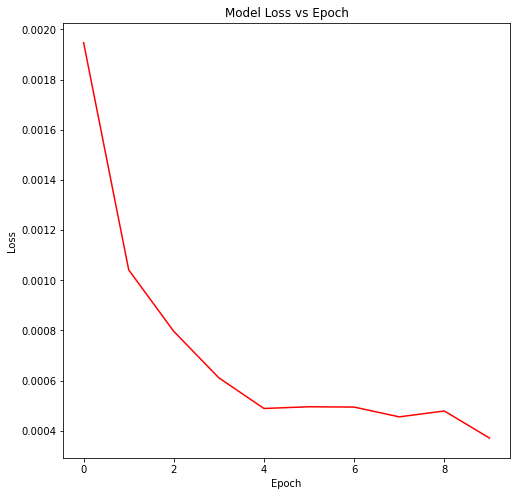

In [14]:
plot.figure(figsize=(8,8))
plot.title('Model Loss vs Epoch')
plot.plot(history.history['loss'], color='red', label='Root Mean Square Error')
plot.ylabel('Loss')
plot.xlabel('Epoch')
plot.legend(loc='best')
plot.show()


# Test the Predictions and RMSE

In [137]:
predictions = model.predict(high_test_x) 
predictions = normalizer.inverse_transform(predictions)
rmse=np.sqrt(np.mean(((predictions- high_test_y)**2)))
print("Root Mean Square Error = ", rmse)

Root Mean Square Error =  14.368369880983478


# Visualize the Predicted Data Vs Validation Data

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


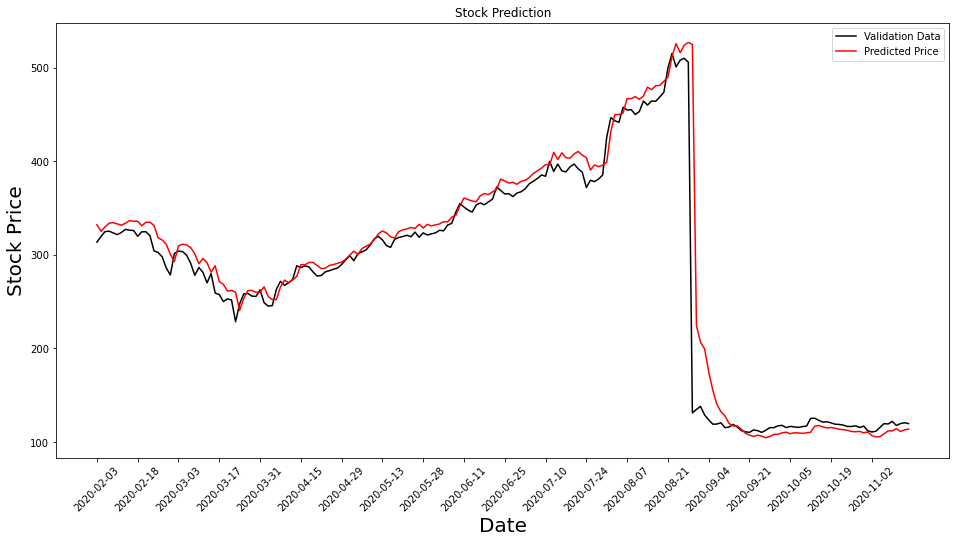

In [135]:
train = date_sorted_columns[:total_training_instances]
valid = date_sorted_columns[total_training_instances:]
valid['Predictions'] = predictions


#Visualize the data
plot.figure(figsize=(16,8))
plot.title('Stock Prediction')

plot.plot(range(200), valid[-200:]['High'], label="Validation Data", color="black")
plot.plot(range(200), predictions[-200:], label="Predicted Price", color="red")
plot.xticks(range(0, 200, 10), valid[-200:]['Date'].loc[::10], rotation=45)
plot.legend(loc='best')
plot.xlabel('Date',fontsize=20)
plot.ylabel('Stock Price',fontsize=20)

plot.show()